### Data Preparation for Bayesian Filter

install dependencies....

In [1]:
!pip install beautifulsoup4

You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
!pip install wordcloud

You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
#we are importing all the libraries we would like to use.
#including data stores for stopwords and such
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import os
import io
%matplotlib inline

### This function reads the files in the specified path.

In [4]:
def read_files(path):
    #this function is reading the actual email files.
    #the function will cycle through all the files in the folder specified.
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            path = os.path.join(root,filename)
            
            inBody = False
            lines = []
            #this uses IO functions to read the files by specifying the encoding type
            f = io.open(path, 'r', encoding = 'latin1')
            #this cycles through each line and fetches the text therein.
            for line in f:
                if inBody:
                    lines.append(line)
                elif line == '\n':
                    inBody = True
            f.close()
            #join the text into a single message.
            message = '\n'.join(lines)
            #return the message
            yield path, message
                    

### This function is for creating dataframes from the dataset in question... it also classifies the emails into either ham or spam

In [5]:
#this classifies the emails into spam or ham depending on predetermined status.
def dataFrameFromDirectory(path, classification):
    #instantiate the structure of the dataframe needed.
    rows = []
    index = []
    #store the message alongside its classification.
    for filename, message in read_files(path):
        rows.append({'message': message, 'label': classification})
        index.append(filename)
        #return the dataframe to be used for manipulation
    return pd.DataFrame(rows, index=index)

aggregate all the emails into a single dataframe. The key is: ham = 0, spam = 1

In [6]:
#fetch the data from the source files.
data = pd.DataFrame({'message':[],'label':[]})
data = data.append(dataFrameFromDirectory("datasets/ham3",0))
data = data.append(dataFrameFromDirectory("datasets/spam3",1))
data

,label,message
datasets/ham3\0006.ee8b0dba12856155222be180ba122058,0.0,"> in adding cream to spaghetti carbonara, whi..."
datasets/ham3\0007.c75188382f64b090022fa3b095b020b0,0.0,\n\n> I just had to jump in here as Carbonara ...
datasets/ham3\0010.4996141de3f21e858c22f88231a9f463,0.0,The Scotsman\n\n\n\n Thu 22 Aug 2002 \n\n\n\n ...
datasets/ham3\0013.ff597adee000d073ae72200b0af00cd1,0.0,"Hello, have you seen and discussed this articl..."
datasets/ham3\0015.a9ff8d7550759f6ab62cc200bdf156e7,0.0,I don't know how make of you are in the Bay Ar...
datasets/ham3\0018.ba70ecbeea6f427b951067f34e23bae6,0.0,--==_Exmh_-1317289252P\n\nContent-Type: text/p...
datasets/ham3\0028.54cf7aa229456fb33194b3a12a713e3e,0.0,\n\n\n\n\n\n> > > > Just cvs up'ed and nowaday...
datasets/ham3\0029.7119e865bff73aca46681d96a451cb60,0.0,"Hey, it's not easy being green.\n\n\n\nleslie\..."
datasets/ham3\0037.0c57a93c0241775d406efecf43ba19cf,0.0,"Thanks Paul,\n\nThat is the way I am doing rig..."
datasets/ham3\0041.af4e0891f17484c10c032f713bce43de,0.0,Chris Haun wrote:\n\n> A LifeGem is a certifie...


The below cell shows the number of rows in our dataframe.

In [7]:
total_mails = data['message'].shape[0]
total_mails

600

The function below extracts all text from html text present in all emails.

In [8]:
#this is for scraping the emails, since most are in the form of html based content.
from bs4 import BeautifulSoup

def func(df):
    soup = BeautifulSoup(df['message'], "html.parser").find()
    #check emails with html syntax
    if bool(soup):
        soup = BeautifulSoup(df['message'], "html.parser")
        #extract text only from the whole email.
    
        text = soup.find_all(text=True)
      
        #return all the words found.
        text = ''.join(word for word in  text)
        df['message'] = text
        
        return text
    else:
        
        return df['message'] 

In [9]:
import email

def using_emailing_function(df):

#     msg = email.message_from_string(df['message'])
#     for part in msg.walk():
#         print(df['message'])
        
    msg = email.message_from_string(df['message'])
    if msg.is_multipart():
        for payload in msg.get_payload():
            # if payload.is_multipart(): ...
#             print(payload.get_payload())
            soup = BeautifulSoup(payload.get_payload(), "lxml").find()
            if bool(soup):
                print(payload.get_payload())
            else:
                print(payload.get_payload())
    else:
        soup = BeautifulSoup(msg.get_payload(), "lxml").find()
        if bool(soup):
                print(msg.get_payload())
#         else:
#             print(msg.get_payload())



In [10]:
new_data = data.reset_index()
new_data

,index,label,message
0,datasets/ham3\0006.ee8b0dba12856155222be180ba1...,0.0,"> in adding cream to spaghetti carbonara, whi..."
1,datasets/ham3\0007.c75188382f64b090022fa3b095b...,0.0,\n\n> I just had to jump in here as Carbonara ...
2,datasets/ham3\0010.4996141de3f21e858c22f88231a...,0.0,The Scotsman\n\n\n\n Thu 22 Aug 2002 \n\n\n\n ...
3,datasets/ham3\0013.ff597adee000d073ae72200b0af...,0.0,"Hello, have you seen and discussed this articl..."
4,datasets/ham3\0015.a9ff8d7550759f6ab62cc200bdf...,0.0,I don't know how make of you are in the Bay Ar...
5,datasets/ham3\0018.ba70ecbeea6f427b951067f34e2...,0.0,--==_Exmh_-1317289252P\n\nContent-Type: text/p...
6,datasets/ham3\0028.54cf7aa229456fb33194b3a12a7...,0.0,\n\n\n\n\n\n> > > > Just cvs up'ed and nowaday...
7,datasets/ham3\0029.7119e865bff73aca46681d96a45...,0.0,"Hey, it's not easy being green.\n\n\n\nleslie\..."
8,datasets/ham3\0037.0c57a93c0241775d406efecf43b...,0.0,"Thanks Paul,\n\nThat is the way I am doing rig..."
9,datasets/ham3\0041.af4e0891f17484c10c032f713bc...,0.0,Chris Haun wrote:\n\n> A LifeGem is a certifie...


In [11]:
new_data[new_data['message'].str.isalnum()]

,index,label,message


split the data into the pareto principle for unbiased model testing.
so 80% will be used for training and 20% for testing.
this will be accomplished by using a random number generator to randomize the order by implementing a uniform distribution randomizer. this removes all chances of having a biased model on account of sequential data.

In [12]:
#split the data into training and testing sets
#initializing empty lists to hold training and testing data respectively
train_index, test_index = list(), list()
for i in range(data['message'].shape[0]):
    #make use of the uniform random distribution to alleviate contiguousness of pseudo-random number generators.
    #80% for training and 20% for testing according to the pareto principle.
    if np.random.uniform(0,1) < 0.80:
        train_index.append(i)
    else:
        test_index.append(i)
#training data dataframe.
train_data = new_data.loc[train_index]
#test data dataframe
test_data = new_data.loc[test_index]

In [13]:
train_data.apply(using_emailing_function, axis = 1)


> I just had to jump in here as Carbonara is one of my favourites to make and 

> ask 

> what the hell are you supposed to use instead of cream? 



Isn't it just basically a mixture of beaten egg and bacon (or pancetta, 

really)? You mix in the raw egg to the cooked pasta and the heat of the pasta 

cooks the egg. That's my understanding.



Martin



------------------------ Yahoo! Groups Sponsor ---------------------~-->

4 DVDs Free +s&p Join Now

http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM

---------------------------------------------------------------------~->



To unsubscribe from this group, send an email to:

forteana-unsubscribe@egroups.com



 



Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/ 







Hello, have you seen and discussed this article and his approach?



Thank you



http://www.paulgraham.com/spam.html

-- "Hell, there are no rules here-- we're trying to accomplish something."

-- Thomas Alva Edison









-------

1      None
3      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
15     None
17     None
18     None
19     None
20     None
21     None
22     None
24     None
25     None
26     None
28     None
30     None
32     None
33     None
34     None
36     None
37     None
38     None
39     None
       ... 
554    None
555    None
557    None
558    None
559    None
560    None
561    None
562    None
564    None
565    None
566    None
567    None
568    None
569    None
570    None
572    None
574    None
575    None
576    None
577    None
581    None
583    None
584    None
589    None
591    None
593    None
594    None
595    None
596    None
598    None
Length: 462, dtype: object

implement the data cleaning of the html based messages
    

In [14]:
#here we  apply the scraping function to our data. hence cleaning it.
train_data['message'] = train_data.apply(func, axis=1)
test_data['message'] = test_data.apply(func, axis=1)
train_data

,index,label,message
1,datasets/ham3\0007.c75188382f64b090022fa3b095b...,0.0,\n\n> I just had to jump in here as Carbonara ...
3,datasets/ham3\0013.ff597adee000d073ae72200b0af...,0.0,"Hello, have you seen and discussed this articl..."
5,datasets/ham3\0018.ba70ecbeea6f427b951067f34e2...,0.0,--==_Exmh_-1317289252P\n\nContent-Type: text/p...
6,datasets/ham3\0028.54cf7aa229456fb33194b3a12a7...,0.0,\n\n\n\n\n\n> > > > Just cvs up'ed and nowaday...
7,datasets/ham3\0029.7119e865bff73aca46681d96a45...,0.0,"Hey, it's not easy being green.\n\n\n\nleslie\..."
8,datasets/ham3\0037.0c57a93c0241775d406efecf43b...,0.0,"Thanks Paul,\n\nThat is the way I am doing rig..."
9,datasets/ham3\0041.af4e0891f17484c10c032f713bc...,0.0,Chris Haun wrote:\n\n> A LifeGem is a certifie...
10,datasets/ham3\0052.40794e238104d6b01f36b0f4d51...,0.0,"Hi,\n\n\n\nThank you for the useful replies, I..."
11,datasets/ham3\0054.a6fa82d1b26c7772829e54ec41a...,0.0,Mark Twomey joked:\n\n> >erm... it runs Solar...
12,datasets/ham3\0058.a7c28223050c35c3a22ac4e2b59...,0.0,\n\nPolitical mail (the snail kind) doesn't bo...


In [15]:
import re

train_data['message'] = train_data['message'].map(lambda x: re.sub(r'\W+', ' ', x))
test_data['message'] = test_data['message'].map(lambda x: re.sub(r'\W+', ' ', x))

In [16]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [17]:
train_data['message'].str.isalnum()

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
432    False
433    False
434    False
435    False
436    False
437    False
438    False
439    False
440    False
441    False
442    False
443    False
444    False
445    False
446    False
447    False
448    False
449    False
450    False
451    False
452    False
453    False
454    False
455    False
456    False
457    False
458    False
459    False
460    False
461    False
Name: message, Length: 462, dtype: bool

In [18]:
test_data

,index,label,message
0,datasets/ham3\0006.ee8b0dba12856155222be180ba1...,0.0,in adding cream to spaghetti carbonara which ...
1,datasets/ham3\0010.4996141de3f21e858c22f88231a...,0.0,The Scotsman Thu 22 Aug 2002 Meaningful senten...
2,datasets/ham3\0015.a9ff8d7550759f6ab62cc200bdf...,0.0,I don t know how make of you are in the Bay Ar...
3,datasets/ham3\0082.7f7858a1a7360410ed120899504...,0.0,Thanks Matthias Actually I got all four speake...
4,datasets/ham3\0094.b7bf14fae9c31d0516cfe00dd9a...,0.0,_ _ _____ _ __ the weekly high tech sarcastic...
5,datasets/ham3\0118.4ebb343d73a83dc935197850e50...,0.0,Reza B Far wrote This thread kind of surprises...
6,datasets/ham3\0125.1ada59664dfcb7a5a31e9820f96...,0.0,BEGIN PGP SIGNED MESSAGE Vincent Cunniffe wro...
7,datasets/ham3\0130.6007e5b54c03026fd924cf2d6b0...,0.0,I just saw the ISOs on an internal server here...
8,datasets/ham3\0138.5bc0323b8aa075bd1e99610b50a...,0.0,John P Looney wrote The only way you can resol...
9,datasets/ham3\0166.f4acdf86d261b60094536bf5a65...,0.0,I managed to get myself an iMac yesterday jus...


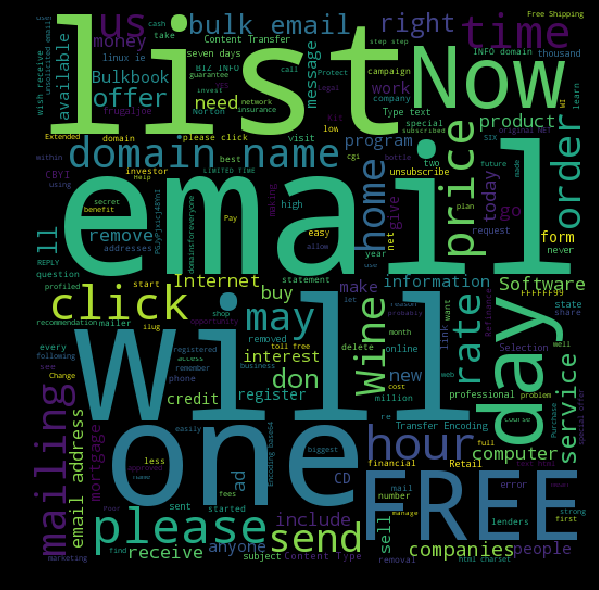

In [19]:
#visual representation of the most salient words.
#this is the visulization for the spam.
spam_words = ' '.join(str(moja) for moja in list(test_data[test_data['label'] == 1]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

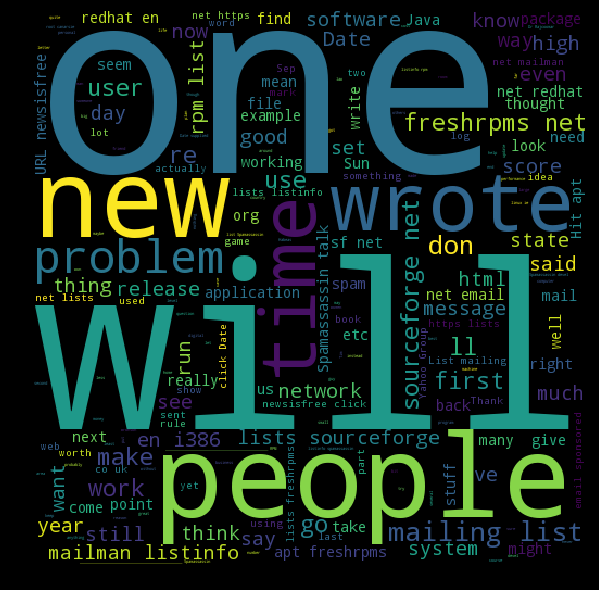

In [20]:
#Visualize the ham data
spam_words = ' '.join(str(moja) for moja in list(test_data[test_data['label'] == 0]['message']))
spamwc = WordCloud(width = 512, height=512).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spamwc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

distribution by value

In [21]:
train_data['label'].value_counts()

0.0    385
1.0     77
Name: label, dtype: int64

in this cell we preprocess the text to be able to be fit into the model.
the first step is to first make all the text lower case for uniformity.
Then we tokenize each message in the dataset.
Tokenization  is the task of splitting up a message into pieces and throwing away the punctuation characters.
The words like ‘go’, ‘goes’, ‘going’ indicate the same activity. We can replace all these words by a single word ‘go’. This is called stemming. We are going to use Porter Stemmer, which is a famous stemming algorithm.

In [22]:
#tokenizing and processing the words harnessed.
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    #lower case all the letters in the message.
    if lower_case:
        message = message.lower()
    #break down the words into tokens.
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
#     print(words)
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        #fetch all words that do not have meaning in this case: stopwords.
        sw = stopwords.words('english')
        #create a list of words containing only the words without stopwords
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
#     print(words)
    return words

In [23]:
train_data.columns

Index(['index', 'label', 'message'], dtype='object')

In [24]:
class SpamClassifier(object):
    def __init__(self, train_data, method = 'tf-idf'):
        #initialize the data to be used for processing. i.e training data.
        self.mails, self.labels = train_data['message'], train_data['label']
        self.method = method

    def train(self):
        #this function trains our model.
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        # initialize variables to calculate probabilities. i.e probability of being ham or spam. using normal probabilistic theory.
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            #if word is spam create a dictionary with the key being the word and the value being the probability of it being spam.
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            #if word is ham, create a dictionary with the key being the ham word and the value being its probability of being ham.
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        self.missing_index = [number for number in range(0,noOfMessages) if number not in self.mails.index ]
        for i in range(noOfMessages):
            if i not in self.missing_index:
                message_processed = process_message(self.mails[i])
                count = list() #To keep track of whether the word has ocured in the message or not.
                               #For IDF
                for word in message_processed:
                    if self.labels[i]:
                        self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                        self.spam_words += 1
                    else:
                        self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                        self.ham_words += 1
                    if word not in count:
                        count += [word]
                for word in count:
                    if self.labels[i]:
                        self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                    else:
                        self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                try:
                    if self.method == 'tf-idf':
                        pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                    else:
                        pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
                except:
                    print('oops')
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                try:
                    if self.method == 'tf-idf':
                        pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                    else:
                        pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
                except:
                    print('oops')
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
        
            result[i] = int(self.classify(processed_message))
        return result

In [25]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [26]:
sc_bow = SpamClassifier(train_data, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(test_data['message'])
metrics(test_data['label'], preds_bow)

Precision:  1.0
Recall:  0.21739130434782608
F-score:  0.3571428571428571
Accuracy:  0.8695652173913043


In [27]:
sc_tf_idf = SpamClassifier(train_data, 'bow')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(test_data['message'])
metrics(test_data['label'], preds_tf_idf)


Precision:  1.0
Recall:  0.21739130434782608
F-score:  0.3571428571428571
Accuracy:  0.8695652173913043


In [28]:
pm = process_message('I cant pick the phone right now. Pls send a message')
sc_tf_idf.classify(pm)

False

In [29]:
pm = process_message('Congratulations ur awarded $500 free  winning report')
sc_tf_idf.classify(pm)

False

In [38]:
test_data[test_data['label'] == 1].iloc[1]['message']

'INTEREST RATES HAVE JUST BEEN CUT NOW is the perfect time to think about refinancing your home mortgage Rates are down Take a minute and fill out our quick online form http www newnamedns com refi Easy qualifying prompt courteous service low rates Don t wait for interest rates to go up again lock in YOUR low rate now To unsubscribe go to http www newnamedns com stopthemailplease Please allow 48 72 hours for removal '

In [31]:
-

SyntaxError: invalid syntax (<ipython-input-31-60215a10e730>, line 1)